In [73]:
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Conv2D, BatchNormalization, Add, Activation, ZeroPadding2D, AveragePooling2D, Flatten
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [74]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [75]:
IMAGE_SIZE = [64, 64]
epochs = 15
batch_size = 128


In [76]:
train_path = "C:\\Users\\sktsa\\Datasets\\blood-cells\\dataset2-master\\dataset2-master\\images\\TRAIN\\"
val_path = "C:\\Users\\sktsa\\Datasets\\blood-cells\\dataset2-master\\dataset2-master\\images\\TEST\\"
test_path = "C:\\Users\\sktsa\\Datasets\\blood-cells\\dataset2-master\\dataset2-master\\images\\TEST_SIMPLE\\"

In [77]:
train_images = glob(train_path + '*/*.jp*g')
val_images = glob(val_path + '*/*.jp*g')

In [78]:
folders = glob(train_path + '/*')
K = len(folders)

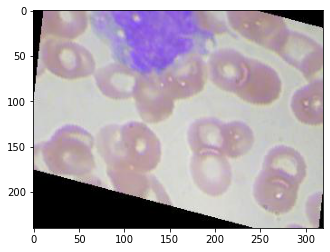

In [79]:
plt.imshow(image.load_img(np.random.choice(train_images)))

In [80]:
#indentity block
def identity_block(X, f, filters):

    F1, F2, F3 = filters
    X_shortcut = X

    #1st compoment
    X = Conv2D(filters=F1,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #2nd component
    X = Conv2D(filters=F2,
               kernel_size=(f, f),
               strides=(1, 1),
               padding='same',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #3rd component
    X = Conv2D(filters=F3,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    #final
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [81]:
#conv block
def convolution_block(X, f, filters, s=2):

    F1, F2, F3 = filters
    X_shortcut = X

    #1st component
    X = Conv2D(filters=F1,
               kernel_size=(1, 1),
               strides=(s, s),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #2nd component
    X = Conv2D(filters=F2,
               kernel_size=(f, f),
               strides=(1, 1),
               padding='same',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #3rd component
    X = Conv2D(filters=F3,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    #final
    X_shortcut = Conv2D(filters=F3,
                        kernel_size=(1, 1),
                        strides=(s, s),
                        padding='valid',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [82]:
def ResNet50(input_shape=IMAGE_SIZE + [3], classes=K):
    """
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
        -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    """
    X_input = Input(input_shape)

    #zero padding
    X = ZeroPadding2D((3, 3))(X_input)

    #Stage 1
    X = Conv2D(64, (7, 7), (2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    #Stage 2
    X = convolution_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])

    #Stage 3
    X = convolution_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])

    #Stage 4
    X = convolution_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    #Stage 5
    X = convolution_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D()(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)
    return model


In [83]:
resnet = ResNet50()
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 32, 32, 64)   9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 32, 32, 64)   256         conv2d_115[0][0]                 
____________________________________________________________________________________________

In [84]:
resnet.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(learning_rate=0.0001),
               metrics=['accuracy'])


In [85]:
def preprocess_input_2(x):
    x /= 127.5
    x -= 1.
    return x

In [86]:
train_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               preprocessing_function=preprocess_input_2)


In [87]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input_2)

In [88]:
test_gen = val_gen.flow_from_directory(val_path,
                                       target_size=IMAGE_SIZE,
                                       class_mode='sparse')
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 2487 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


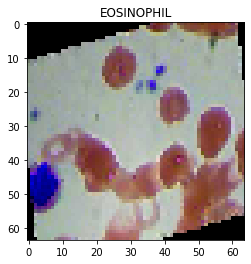

In [89]:
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break


In [90]:
train_generator = train_gen.flow_from_directory(train_path,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                class_mode='sparse')

val_generator = val_gen.flow_from_directory(val_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size,
                                            class_mode='sparse')


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [91]:
checkpoint = 'checkpoints/'
r = resnet.fit(train_generator,
               validation_data=val_generator,
               epochs=epochs,
               steps_per_epoch=len(train_images) // batch_size,
               validation_steps=len(val_images) // batch_size,
               callbacks=[
                   EarlyStopping(monitor='loss',
                                 patience=3,
                                 restore_best_weights=True),
                   ModelCheckpoint(filepath=checkpoint,
                                   save_weights_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_best_only=True)
               ])


Epoch 1/15
77/77 [==============================] - 35s 406ms/step - loss: 1.9159 - accuracy: 0.2634 - val_loss: 1.3890 - val_accuracy: 0.2512
Epoch 2/15
77/77 [==============================] - 25s 322ms/step - loss: 1.6133 - accuracy: 0.2683 - val_loss: 1.4032 - val_accuracy: 0.2405
Epoch 3/15
77/77 [==============================] - 26s 331ms/step - loss: 1.5216 - accuracy: 0.2925 - val_loss: 1.4944 - val_accuracy: 0.2558
Epoch 4/15
77/77 [==============================] - 25s 323ms/step - loss: 1.4090 - accuracy: 0.3501 - val_loss: 1.5751 - val_accuracy: 0.2738
Epoch 5/15
77/77 [==============================] - 25s 328ms/step - loss: 1.2925 - accuracy: 0.4027 - val_loss: 1.4192 - val_accuracy: 0.4194
Epoch 6/15
77/77 [==============================] - 25s 328ms/step - loss: 1.1796 - accuracy: 0.4635 - val_loss: 1.3124 - val_accuracy: 0.4050
Epoch 7/15
77/77 [==============================] - 25s 323ms/step - loss: 1.0627 - accuracy: 0.5158 - val_loss: 1.4187 - val_accuracy: 0.4396

<AxesSubplot:>

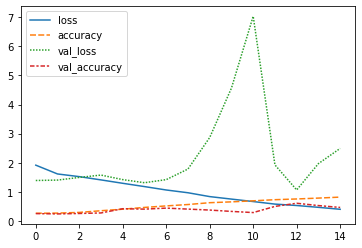

In [92]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame.from_dict(r.history)
sns.lineplot(data=df)